In [1]:
from datasets import load_dataset
from utils import mp3_compress, opus_compress, encodec_compress
from utils import hf_audio_encode
from transformers import pipeline
from evaluate import evaluator
import encodec
import matplotlib.pyplot as plt
import numpy as np

2023-10-25 11:14:22.381146: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-25 11:14:22.400335: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 11:14:22.400352: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 11:14:22.400368: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 11:14:22.404542: I tensorflow/core/platform/cpu_feature_g

In [2]:
def mp3_compress_cv(sample):
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    audio,bps = mp3_compress(audio,fs)
    encoded = hf_audio_encode(audio,fs)
    sample['audio'] = encoded
    sample['bps'] = bps
    return sample
def opus_compress_cv(sample):
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    audio,bps = opus_compress(audio,fs)
    encoded = hf_audio_encode(audio,fs)
    sample['audio'] = encoded
    sample['bps'] = bps
    return sample

device = "cuda"
encodec_model_48_3 = encodec.EncodecModel.encodec_model_48khz()
encodec_model_48_3.set_target_bandwidth(6)
encodec_model_48_3.to(device)
def encodec_48_3_compress(sample):
    audio = sample['audio']['array'].unsqueeze(0)
    fs = sample['audio']['sampling_rate']
    audio,bps = encodec_compress(audio,fs, encodec_model_48_3, device)
    encoded = hf_audio_encode(audio,fs)
    sample['audio'] = encoded
    sample['bps'] = bps
    return sample 

In [3]:
audio_compression_methods = [
    mp3_compress_cv,
    opus_compress_cv,
    encodec_48_3_compress
]
models = [
    "openai/whisper-tiny",
    # "openai/whisper-small",
    "openai/whisper-medium"
]

In [4]:
common_voice = load_dataset("mozilla-foundation/common_voice_11_0",
                             "en",
                             split="validation[:802]"
                            ).with_format("torch")

In [5]:
exclude_idx = [362, 711]
common_voice = [common_voice.select(
    (
        i for i in range(len(common_voice)) 
        if i not in set(exclude_idx)
    )
)]

Parameter 'indices'=<generator object <genexpr> at 0x7f76dd685620> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [ ]:
for method in audio_compression_methods:
    common_voice.append(common_voice[0].map(method))

In [7]:
pipe = []
for model in models:
    pipe.append(
        pipeline(
            task="automatic-speech-recognition",
            model=model,
            device="cuda:0"
        )
    )

In [8]:
task_evaluator = evaluator("automatic-speech-recognition")
task_evaluator.PIPELINE_KWARGS.pop('truncation', None)

True

In [9]:
eval_results = []
for i_method,method in enumerate(common_voice):
    eval_results.append([])
    for i_model,model in enumerate(pipe):
        eval_results[i_method].append(
            task_evaluator.compute(
                model_or_pipeline=model,
                data=method.with_format("numpy"),
                input_column="audio",
                label_column="sentence",
                metric="wer",
            )
        )

In [10]:
asr_wer = np.array([[rij['wer'] for rij in r] for r in eval_results])
asr_wer

array([[0.32112639, 0.15111052],
       [0.4617927 , 0.19275516],
       [0.54561079, 0.24643046],
       [0.49788472, 0.20491803]])

In [11]:
baseline_wer = asr_wer[0,1]
asr_wer = asr_wer[1:,1]

In [12]:
audio_bps = [method['bps'].mean() for method in common_voice[1:]]
audio_bps

[tensor(0.6700), tensor(0.1470), tensor(0.1262)]

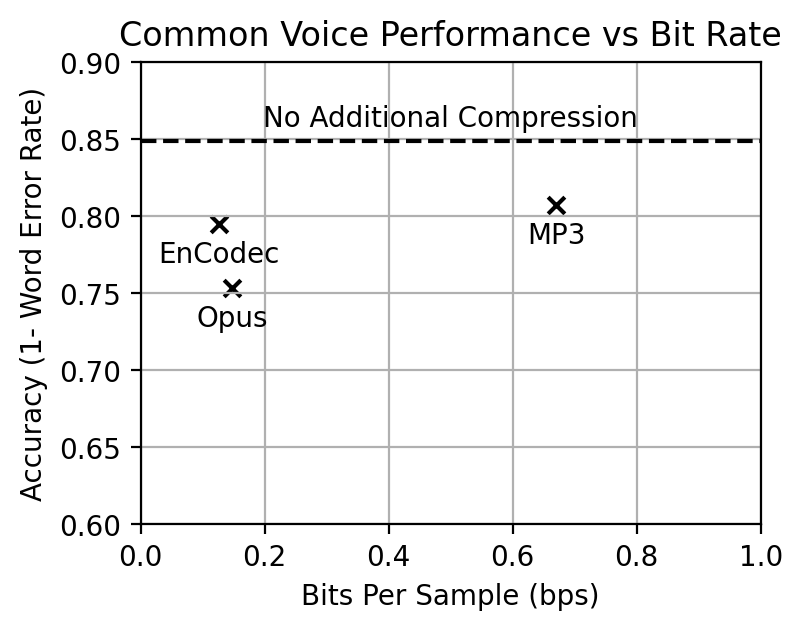

In [13]:
audio_compression_names = [
    'MP3',
    'Opus',
    'EnCodec',
]
plt.figure(figsize=(4, 3),dpi=200)
plt.scatter(audio_bps, 1-asr_wer, c='black', marker='x')
plt.annotate("No Additional Compression", (0.5, 1-baseline_wer), textcoords="offset points", xytext=(0,5), ha='center')
plt.plot([0,1],[1-baseline_wer,1-baseline_wer],'--',c='black')
for i, name in enumerate(audio_compression_names):
    plt.annotate(name, (audio_bps[i], 1-asr_wer[i]), textcoords="offset points", xytext=(0,-14), ha='center')
plt.xlabel('Bits Per Sample (bps)')
plt.ylabel('Accuracy (1- Word Error Rate)')
plt.title('Common Voice Performance vs Bit Rate')
plt.xlim([0,1])
plt.ylim([0.6,0.9])
plt.grid(True)
plt.show()